# Train an Oracle model with the complete traffic captures

In our use case, we suppose this model is given at the end of a Federated Learning training among organisations. Each one participates by providing its traffic samples, which potentially vary in data distribution and traffic nature, such as benign, DDoS, or other attacks. For the sake of testing, we train a model in the old-fashioned way.

In [8]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib as mpl
from sklearn.metrics import accuracy_score

from intellect.model.sklearn.model import EnhancedMlpRegressor
from intellect.io import dump, create_dir, load
from intellect.inspect import set_seed
from intellect.scoring import compute_metric_percategory
import os
import config

# lines to decrease plot quality and notebook size
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
mpl.rcParams['figure.dpi']= 70

import threadpoolctl
threadpoolctl.threadpool_limits(limits=int(os.cpu_count()/4));

Load the dataset and split it into 4 portions, but consider only train and validation for this step.

In [9]:
train, validation, _ = config.get_dataset()

In [3]:
create_dir(config.TRAINING_OUTPUT_DIR)

Proceed with the Oracle network creation and training.

In [10]:
set_seed()
oracle = EnhancedMlpRegressor(train.classes, dropout=config.DROPOUT_HIDDEN,
                              hidden_layer_sizes=(config.N_HIDDEN_UNITS,)*config.N_HIDDEN_LAYERS,
                              learning_rate=config.LEARNING_RATE, activation=config.ACTIVATION)
history = oracle.fit(train, validation_dataset=validation, batch_size=config.BATCH_SIZE,
                     max_epochs=config.MAX_EPOCHS, epochs_wo_improve=config.EPOCHS_WO_IMPROVE, verbose=True);

  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss_train': 0.00888820667389158, 'accuracy_score_train': 0.9777883315676031, 'loss_validation': 0.008793395941331819, 'accuracy_score_validation': 0.9774195869612147}:   7%|▋         | 67/1000 [03:59<55:33,  3.57s/it] 


Save the obtained model and its history, and visualise the history metrics.

In [11]:
oracle.save(config.TRAINING_OUTPUT_MODEL)
history_df = pd.DataFrame(history)
dump(history_df, config.TRAINING_OUTPUT_DIR + "oracle_history.csv")

Plot history and reload data.

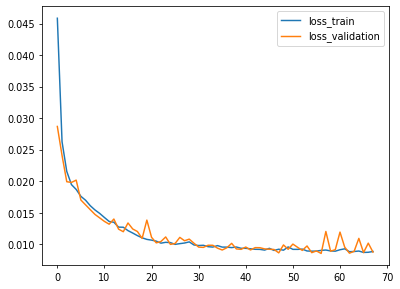

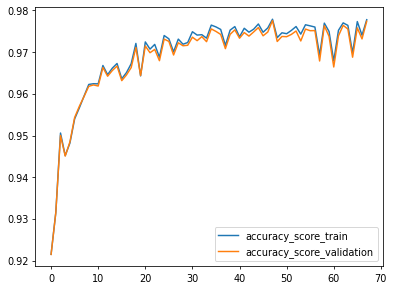

In [12]:
history_df = load(config.TRAINING_OUTPUT_DIR + "oracle_history.csv", index_col=0)
history_df[["loss_train", "loss_validation"]].plot();
history_df[["accuracy_score_train", "accuracy_score_validation"]].plot();

Finally, test the oracle model against the validation set, used for the early stop condition.

In [13]:
oracle = EnhancedMlpRegressor.load(config.TRAINING_OUTPUT_MODEL)

pd.DataFrame(compute_metric_percategory(validation.y, oracle.predict(validation.X), validation._y, scorer=accuracy_score), index=["Oracle Accuracy"])

,Global,BENIGN,Bot,DDoS,DoS GoldenEye,DoS Hulk,DoS Slowhttptest,DoS slowloris,DrDoS_DNS,DrDoS_LDAP,DrDoS_MSSQL,DrDoS_NTP,DrDoS_NetBIOS,DrDoS_SNMP,DrDoS_SSDP,DrDoS_UDP,FTP-Patator,Heartbleed,Infiltration,LDAP,MSSQL,NetBIOS,PortScan,Portmap,SSH-Patator,Syn,TFTP,UDP,UDP-lag,UDPLag,Web Attack Brute Force,Web Attack Sql Injection,Web Attack XSS,WebDDoS
Oracle Accuracy,0.977578,0.97778,0.610922,0.982667,0.988667,0.900667,0.992727,0.995397,0.997333,0.999333,1.0,0.998667,0.999333,1.0,0.999333,0.999333,0.997481,0.0,0.2,1.0,0.999333,1.0,0.938667,0.998667,0.722851,0.996667,0.997333,1.0,0.995333,0.907473,0.929204,0.333333,0.938776,0.30303
